In [2]:
import sys
sys.path.insert(0, "../")
import numpy as np
from dataset import create_dataset_approx
from structure_compare.compare_pairs import StructureComparePair
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

/home/acowlagi/envs/torch_py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_set, _, _, test_set = create_dataset_approx("cifar10")
x_train, y_train, x_test, y_test = train_set.data/255.0, train_set.targets, test_set.data/255.0, test_set.targets

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/home/acowlagi/2022-experiments/encoding-structures-of-neural-representations/notebooks/../dataset.py:47: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  data1_list.append(dataset.data[idx][:n1//(d+1)])
/home/acowlagi/2022-experiments/encoding-structures-of-neural-representations/notebooks/../dataset.py:48: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, roundin

In [4]:
def compute_bc(structure_compare_pair: StructureComparePair, window_size: int, stride = None, verbose = True):
    bc_dists = []
    bc_coeffs = []

    interval = 1 if stride is None else stride
    inds = np.arange(0, structure_compare_pair.all_retained_vals - window_size, interval)

    for i in range(0, structure_compare_pair.all_retained_vals - window_size, interval):
        if (verbose and i % 50 == 0):
            print(f"Current Index: {i}")
        
        relevant_x1 = structure_compare_pair.x1_proj_coeffs[:, i:i + window_size]
        relevant_x2 = structure_compare_pair.x2_proj_coeffs[:, i:i + window_size]

        mu_1 = relevant_x1.mean(axis = 0)
        mu_2 = relevant_x2.mean(axis = 0)

        cov_x1 = np.cov(relevant_x1 - mu_1, rowvar = False)
        cov_x2 = np.cov(relevant_x2 - mu_2, rowvar = False)
        cov = (cov_x1 + cov_x2)/2
        det1, det2, det  = np.linalg.det(cov_x1), np.linalg.det(cov_x2), np.linalg.det(cov)

        bc_dist = (1/8)*(mu_1 - mu_2).T @ np.linalg.inv(cov) @ (mu_1 - mu_2) + \
            (1/2) * np.log(det / np.sqrt(det1*det2))

        bc_coeff = np.exp(-bc_dist)

        bc_dists.append(bc_dist)
        bc_coeffs.append(bc_coeff)

    return (np.array(bc_dists), inds), (np.array(bc_coeffs), inds)


In [5]:
bc_coeffs_all_pairs = {}
bc_dist_all_pairs = {}
align_all_pairs = {}

for cls1 in range(10):
    for cls2 in range(cls1, 10):
        print(f"Class Pair: {(cls1, cls2)}")
        cls1_examples, cls2_examples = x_train[y_train == cls1], x_train[y_train == cls2]
        cls1_examples = cls1_examples.reshape(cls1_examples.shape[0], -1)
        cls2_examples = cls2_examples.reshape(cls2_examples.shape[0], -1)

        all_examples = np.vstack((cls1_examples, cls2_examples))
        num_divisions = None

        compare_pair = StructureComparePair(x1= cls1_examples, x2= cls2_examples, x_other = all_examples, retain_var= 0.96, num_divisions = num_divisions, set_all= True)
        bc_dist_all_pairs[(cls1, cls2)], bc_coeffs_all_pairs[(cls1, cls2)] = compute_bc(compare_pair, window_size = 30, stride = 10, verbose = False)
        align_all_pairs[(cls1, cls2)] = compare_pair.compute_class_overlap(window_size=30, stride = 10)


Class Pair: (0, 0)
Class Pair: (0, 1)
Class Pair: (0, 2)
Class Pair: (0, 3)
Class Pair: (0, 4)
Class Pair: (0, 5)
Class Pair: (0, 6)
Class Pair: (0, 7)
Class Pair: (0, 8)
Class Pair: (0, 9)
Class Pair: (1, 1)
Class Pair: (1, 2)
Class Pair: (1, 3)
Class Pair: (1, 4)
Class Pair: (1, 5)
Class Pair: (1, 6)
Class Pair: (1, 7)
Class Pair: (1, 8)
Class Pair: (1, 9)
Class Pair: (2, 2)
Class Pair: (2, 3)
Class Pair: (2, 4)
Class Pair: (2, 5)
Class Pair: (2, 6)
Class Pair: (2, 7)
Class Pair: (2, 8)
Class Pair: (2, 9)
Class Pair: (3, 3)
Class Pair: (3, 4)
Class Pair: (3, 5)
Class Pair: (3, 6)
Class Pair: (3, 7)
Class Pair: (3, 8)
Class Pair: (3, 9)
Class Pair: (4, 4)
Class Pair: (4, 5)
Class Pair: (4, 6)
Class Pair: (4, 7)
Class Pair: (4, 8)
Class Pair: (4, 9)
Class Pair: (5, 5)
Class Pair: (5, 6)
Class Pair: (5, 7)
Class Pair: (5, 8)
Class Pair: (5, 9)
Class Pair: (6, 6)
Class Pair: (6, 7)
Class Pair: (6, 8)
Class Pair: (6, 9)
Class Pair: (7, 7)
Class Pair: (7, 8)
Class Pair: (7, 9)
Class Pair: 

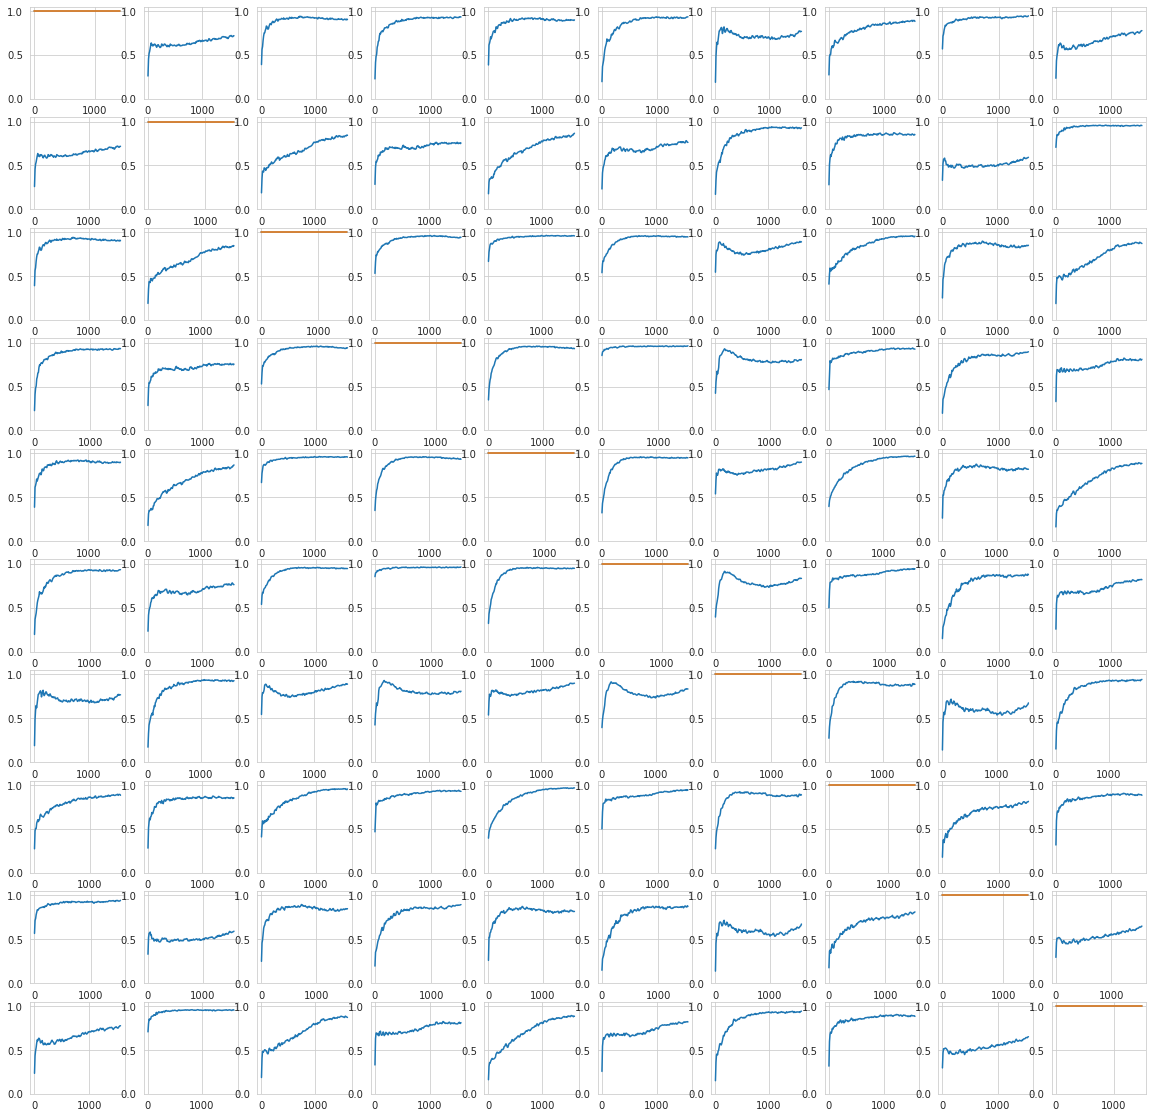

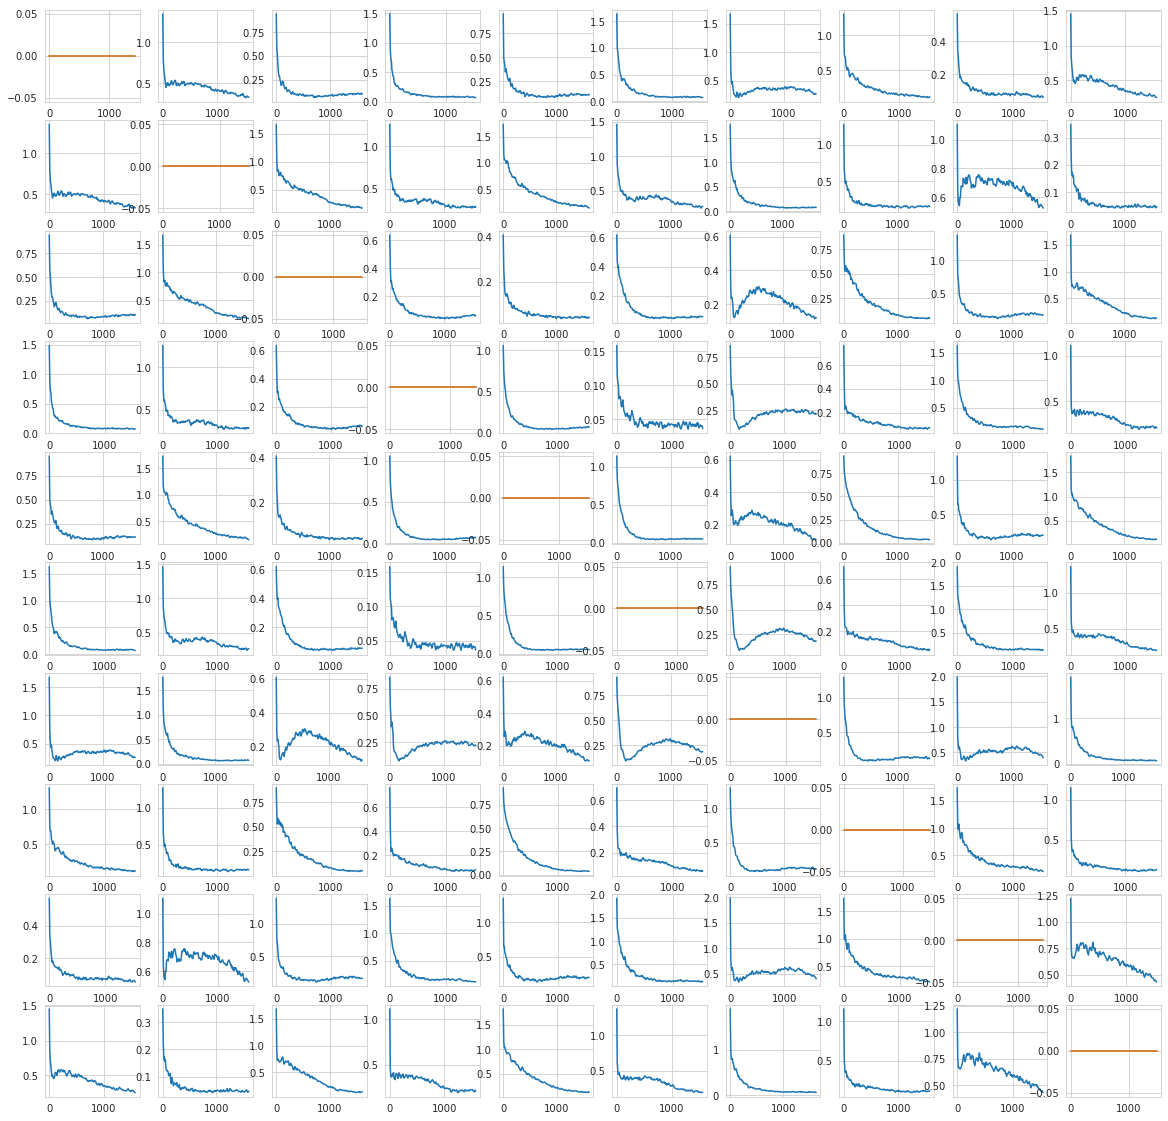

In [8]:
fig1, ax1 = plt.subplots(10, 10, figsize = (20, 20))
fig2, ax2 = plt.subplots(10, 10, figsize = (20, 20))
for i in range(10):
    for j in range(i, 10):
        to_plot_bc_coeff, inds = bc_coeffs_all_pairs[(i,j)]
        to_plot_bc_dist, inds = bc_dist_all_pairs[(i,j)]

        ax1[i, j].plot(inds, to_plot_bc_coeff)
        ax1[i, j].set_ylim([0, 1.05])

        ax1[j, i].plot(inds, to_plot_bc_coeff)
        ax1[j, i].set_ylim([0, 1.05])
   
        ax2[i, j].plot(inds, to_plot_bc_dist)

        ax2[j, i].plot(inds, to_plot_bc_dist)


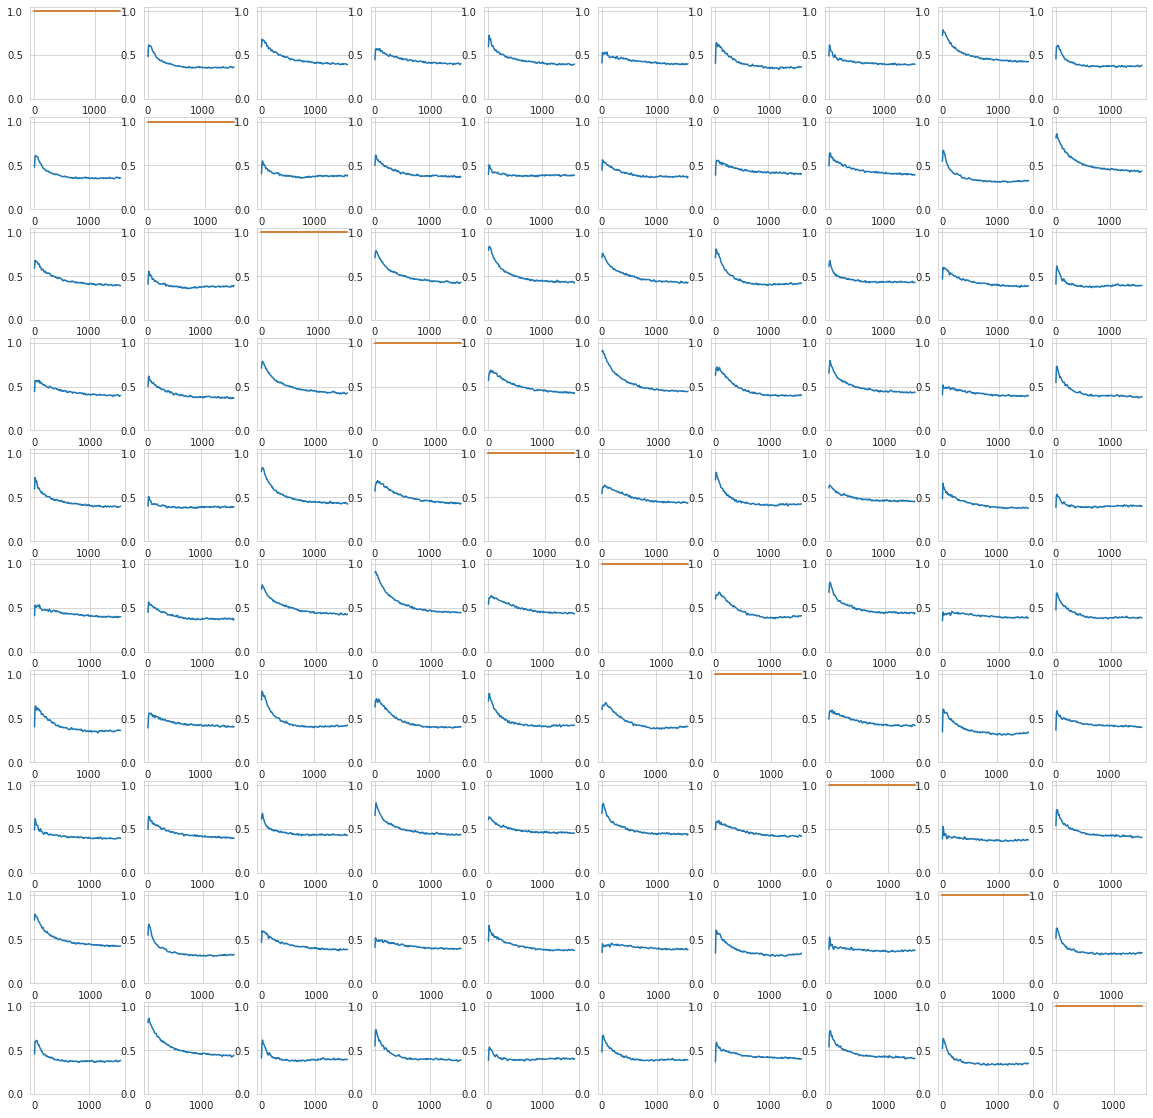

In [9]:
fig1, ax1 = plt.subplots(10, 10, figsize = (20, 20))
average_diff = np.zeros((10,10))

for i in range(10):
    for j in range(i, 10):
        overlap, inds = bc_coeffs_all_pairs[(i,j)]
        align = align_all_pairs[(i,j)]

        ax1[i, j].plot(inds, np.sqrt(align * overlap))
        ax1[i, j].set_ylim([0, 1.05])

        ax1[j, i].plot(inds, np.sqrt(align * overlap))
        ax1[j, i].set_ylim([0, 1.05])

        average_diff[i, j] = np.sqrt(align * overlap).mean()
   


/tmp/ipykernel_16239/1882027960.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

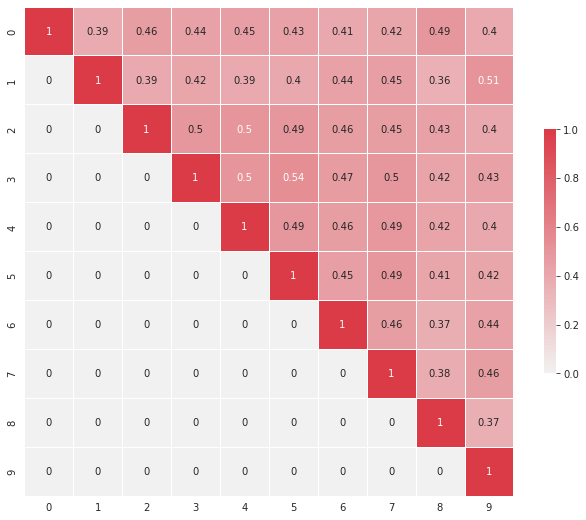

In [13]:
corr = average_diff
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=None, vmax=1, vmin = 0, center=0,
            annot = True, square=True, linewidths=.5, cmap = cmap, cbar_kws={"shrink": .5})